# Final Project

In [66]:
!pip install yfinance torchsde fredapi

In [67]:
!pip install yahooquery

In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchsde
import matplotlib.pyplot as plt
from fredapi import Fred


API: eceed27c47582f947792a9947d285202

In [69]:
# === 配置 ===
FRED_API_KEY = "eceed27c47582f947792a9947d285202"  # 替换成你的FRED key
fred = Fred(api_key=FRED_API_KEY)


In [70]:
!pip install alpha_vantage

In [71]:
from alpha_vantage.timeseries import TimeSeries as ts
api_key = "你的API密钥"


In [72]:
import os

start_date = "2013-06-01"
end_date = "2025-05-31"

FRED_API_KEY = "eceed27c47582f947792a9947d285202"  # 替换为你的
fred = Fred(api_key=FRED_API_KEY)
# ========== 创建数据文件夹 ==========
os.makedirs("data_cache", exist_ok=True)

# ========== 1. 获取并保存 VIX ==========
vix_path = "data_cache/vix.csv"
if os.path.exists(vix_path):
    vix = pd.read_csv(vix_path, index_col=0, parse_dates=True)
else:
    vix_series = fred.get_series("VIXCLS", start_date=start_date, end_date=end_date)
    vix = pd.DataFrame(vix_series, columns=["vix"])
    vix.index.name = "date"
    vix.to_csv(vix_path)
print("✅ VIX 数据加载完成")

# ========== 2. 获取并保存 SPY ==========
spy_path = "data_cache/spy.csv"
if os.path.exists(spy_path):
    spy = pd.read_csv(spy_path, index_col=0, parse_dates=True)
else:
    try:
        print(f"开始下载 spy 历史数据...")
        spy, meta_spy = ts.get_daily(symbol='spy', outputsize='full')
        spy.columns = ['open', 'high', 'low', 'close', 'volume']
        spy.index = pd.to_datetime(spy.index)
        spy.sort_index(inplace=True)
        spy = spy.loc[start_date: end_date]
        spy = spy[["close"]].rename(columns={"close": name})
        spy.to_csv(spy_path)
        print(f"✅ spy 下载成功")
    except Exception as e:
        print(f"❌ 下载失败 spy:", e)
print("✅ SPY 数据加载完成")

# ========== 3. 获取并保存 AAPL ==========
aapl_path = "data_cache/aapl.csv"
if os.path.exists(aapl_path):
    aapl = pd.read_csv(aapl_path, index_col=0, parse_dates=True)
else:
    try:
        print(f"开始下载 aapl 历史数据...")
        aapl, meta = ts.get_daily(symbol='aapl', outputsize='full')
        aapl.columns = ['open', 'high', 'low', 'close', 'volume']
        aapl.index = pd.to_datetime(aapl.index)
        aapl.sort_index(inplace=True)
        aapl = aapl.loc[start_date: end_date]
        aapl = aapl[["close"]].rename(columns={"close": name})
        aapl.to_csv(aapl_path)
        print(f"✅ aapl 下载成功")
    except Exception as e:
        print(f"❌ 下载失败 aapl:", e)
print("✅ AAPL 数据加载完成")


✅ VIX 数据加载完成
✅ SPY 数据加载完成
✅ AAPL 数据加载完成


In [73]:
!pip install pycoingecko

In [74]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies
start_date = "2013-06-01"
end_date = "2025-05-31"
cc = CryptoCurrencies(key=api_key, output_format='pandas')
name = "bitcoin"
btc_path = "data_cache/bitcoin.csv"
if os.path.exists(btc_path):
    bitcoin = pd.read_csv(btc_path, index_col=0, parse_dates=True)
else:
    try:
        print(f"开始下载 {name} 历史数据...")
        bitcoin, meta = cc.get_digital_currency_daily(symbol='BTC', market='USD')
        bitcoin.columns = [col.lower().split('. ')[-1] for col in bitcoin.columns]
        bitcoin.index = pd.to_datetime(bitcoin.index)
        bitcoin.sort_index(inplace=True)
        bitcoin = bitcoin.loc[start_date:end_date]
        bitcoin = bitcoin[["close"]].rename(columns={"close": name})
        bitcoin.to_csv(btc_path)
        print(f"✅ {name.upper()} 下载成功")
    except Exception as e:
        print(f"❌ 下载失败 {name}:", e)

In [76]:
vix = vix[vix.index >= start_date]
print(vix.head())
print(spy.head())

              vix
date             
2013-06-03  16.28
2013-06-04  16.27
2013-06-05  17.50
2013-06-06  16.63
2013-06-07  15.14
              aapl
date              
2013-06-03  164.35
2013-06-04  163.56
2013-06-05  161.27
2013-06-06  162.73
2013-06-07  164.80


In [77]:
df_stocks = pd.read_csv("data_cache/df.csv", index_col=0, parse_dates=True)
print(df_stocks.head())
print(df_stocks.tail())

               spy    vix     aapl
date                              
2013-06-03  164.35  16.28  450.720
2013-06-04  163.56  16.27  449.310
2013-06-05  161.27  17.50  445.110
2013-06-06  162.73  16.63  438.460
2013-06-07  164.80  15.14  441.811
               spy    vix    aapl
date                             
2025-05-23  579.11  22.29  195.27
2025-05-27  591.15  18.96  200.21
2025-05-28  587.73  19.31  200.42
2025-05-29  590.05  19.18  199.95
2025-05-30  589.39  18.57  200.85


## 以下是宏观经济数据

### EPU

In [78]:
# === 2. EPU Index ===
epu_us = pd.read_csv("data/All_Daily_Policy_Data.csv")
epu_us["date"] = pd.to_datetime(epu_us[["year", "month", "day"]])
epu_us = epu_us.sort_values("date")

# 过滤出 2014-06-01 之后的数据
epu_us = epu_us[epu_us["date"] >= pd.Timestamp("2013-06-01")]
epu_us = epu_us.set_index("date")
# 这里有一个归一化，如果去掉会怎么样呢？
epu_us["daily_policy_index"] = (epu_us["daily_policy_index"] - epu_us["daily_policy_index"].mean()) / epu_us["daily_policy_index"].std()
print("EPU Index 数据预览：", epu_us.head())

EPU Index 数据预览：             day  month  year  daily_policy_index
date                                            
2013-06-01    1      6  2013           -0.568632
2013-06-02    2      6  2013           -0.592437
2013-06-03    3      6  2013           -0.416366
2013-06-04    4      6  2013           -0.635633
2013-06-05    5      6  2013           -0.613473


### CCI

In [79]:
import pandas as pd
import yfinance as yf
from fredapi import Fred

# === 配置 ===
FRED_API_KEY = "eceed27c47582f947792a9947d285202"  # 替换成你的FRED key
fred = Fred(api_key=FRED_API_KEY)

# === 获取 CCI 数据 ===
cci = fred.get_series("UMCSENT")  # University of Michigan Consumer Sentiment

# === 处理成月度数据 ===
cci = cci.resample("ME").last().dropna()
cci_df = cci.to_frame("cci")  # 转为DataFrame
cci_df["month"] = cci_df.index.to_period("M").astype(str)
cci_df = cci_df.reset_index(drop=True)

# === 保存为 CSV 文件 ===
cci_df.to_csv("data_cache/cci_index.csv", index=False)
print("✅ 成功保存为 cci_index.csv")
print(cci_df.tail())


✅ 成功保存为 cci_index.csv
      cci    month
655  74.0  2024-12
656  71.7  2025-01
657  64.7  2025-02
658  57.0  2025-03
659  52.2  2025-04


In [80]:
from pathlib import Path
cci_csv_path = Path("data_cache/cci_index.csv")

if cci_csv_path.exists():
    print("📂 已检测到 cci_index.csv，读取中...")
    cci_df = pd.read_csv(cci_csv_path)
else:
    print("📂 未检测到 cci_index.csv.")

start_month = "2013-06"
end_month = "2024-05"

cci_df = cci_df[(cci_df["month"] >= start_month) & (cci_df["month"] <= end_month)]
cci_df = cci_df.reset_index(drop=True)

print(cci_df.head())
    

📂 已检测到 cci_index.csv，读取中...
    cci    month
0  84.1  2013-06
1  85.1  2013-07
2  82.1  2013-08
3  77.5  2013-09
4  73.2  2013-10


### Treasury ETFs
- TLT（iShares 20+ Year Treasury Bond ETF）
  - 投资标的：美国长期国债，期限一般是20年以上的国债。
  - 特点：
    - 持有期限最长，波动性较大；
    - 对利率变化非常敏感；
    - 收益率通常较高，因为长期债券利率更高

- IEF（iShares 7-10 Year Treasury Bond ETF）
  - 投资标的：中期美国国债，期限一般在7到10年之间。
  - 特点：
    - 风险和收益介于长期和短期债券之间；
    - 价格对利率变化的敏感度适中；
    - 收益和波动较TLT低，但高于SHY

- SHY（iShares 1-3 Year Treasury Bond ETF）
  - 投资标的：短期美国国债，期限为1至3年。
  - 特点：
    - 风险最低，波动小；
    - 收益较低，但流动性好；
    - 对利率变动敏感度最低

In [81]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

api_key = "你的API密钥"
ts = TimeSeries(key=api_key, output_format='pandas')


etfs = ["TLT", "IEF", "SHY"]
etf_data = {}


def download_treasury_etf(symbol, start_date, end_date):
    for symbol in etfs:
        print(f"📥 正在下载 {symbol}...")
        data, _ = ts.get_daily(symbol=symbol, outputsize='full')
        data = data.rename(columns={
            "1. open": "open",
            "2. high": "high",
            "3. low": "low",
            "4. close": f"{symbol}_close",
            "5. volume": "volume"
        })
        data.index = pd.to_datetime(data.index)
        data = data[[f"{symbol}_close"]].sort_index()
        etf_data[symbol] = data

# 合并3个ETF的收盘价
    df = etf_data["TLT"].join(etf_data["IEF"]).join(etf_data["SHY"])
    df = df.loc["2013-06-01":"2024-05-31"]
    df.to_csv("data_cache/bond_etf_prices_alpha.csv")
    print("✅ 保存为 bond_etf_prices_alpha.csv")
    print(df.tail())


treasuries_path = "data_cache/bond_etf_prices_alpha.csv"
if Path(treasuries_path).exists():
    print("📂 已检测到 bond_etf_prices_alpha.csv，读取中...")
    etf_data = pd.read_csv("data_cache/bond_etf_prices_alpha.csv")
    print(etf_data.head())
else:
    print("📂 未检测到 bond_etf_prices_alpha.csv，开始下载数据...")


📂 已检测到 bond_etf_prices_alpha.csv，读取中...
         date  TLT_close  IEF_close  SHY_close
0  2013-06-03     114.78     105.33      84.39
1  2013-06-04     113.72     105.06      84.39
2  2013-06-05     115.29     105.57      84.40
3  2013-06-06     115.22     105.70      84.39
4  2013-06-07     113.16     104.88      84.38


In [82]:
treasury_etf = etf_data.copy()

# 确保索引是日期格式
treasury_etf = treasury_etf.set_index(treasury_etf['date'], drop=True)
treasury_etf = treasury_etf.drop(columns=['date'])
print(treasury_etf.head())



            TLT_close  IEF_close  SHY_close
date                                       
2013-06-03     114.78     105.33      84.39
2013-06-04     113.72     105.06      84.39
2013-06-05     115.29     105.57      84.40
2013-06-06     115.22     105.70      84.39
2013-06-07     113.16     104.88      84.38


In [83]:
# === 6. 初请失业金人数（ICSA）===

claims_csv_path = Path("data_cache/jobless_claims.csv")

def download_jobless_claims():
    print("🔄 下载初请失业金人数（ICSA）...")
    claims = fred.get_series("ICSA")  # 每周四发布
    claims = claims.resample("W-MON").mean().dropna()  # 周频 → 对齐为每周一
    claims = claims.resample("M").mean()  # 月平均
    claims_df = claims.to_frame("jobless_claims")
    claims_df["month"] = claims_df.index.to_period("M").astype(str)
    claims_df = claims_df.reset_index(drop=True)
    claims_df.to_csv(claims_csv_path, index=False)
    print("✅ 成功保存为 jobless_claims.csv")
    return claims_df

# === 主逻辑：判断文件是否存在 ===
if claims_csv_path.exists():
    print("📂 已检测到 jobless_claims.csv，读取中...")
    claims_df = pd.read_csv(claims_csv_path)
else:
    claims_df = download_jobless_claims()

claims_df = claims_df[(claims_df["month"] >= start_month) & (claims_df["month"] <= end_month)]
claims_df = claims_df.reset_index(drop=True)

print(claims_df.head())
print(claims_df.tail())

📂 已检测到 jobless_claims.csv，读取中...
   jobless_claims    month
0        345750.0  2013-06
1        344800.0  2013-07
2        335500.0  2013-08
3        316200.0  2013-09
4        358500.0  2013-10
     jobless_claims    month
127        207600.0  2024-01
128        210750.0  2024-02
129        213000.0  2024-03
130        212800.0  2024-04
131        222000.0  2024-05


## 数据处理

我们接下来要合并所有的数据：
- spy: sp500指数（每交易日）
- vix：每交易日
- aapl：苹果股价（每交易日）
- 以上三个合并为一个dataframe：df_stocks, index是date，其他列名是spy, vix, aapl
- epu_us：每月，索引为从0开始的数字
- CCI：每月，索引是从0开始的数字
- 国债价格（每交易日），索引是从0开始的数字，其他列是date, TLT_close, IEF_close, SHY_close
- ICSA: 失业金人数（每月），索引是从0开始的数字

In [84]:
df_stocks.head()

,spy,vix,aapl
date,,,
2013-06-03,164.35,16.28,450.720
2013-06-04,163.56,16.27,449.310
2013-06-05,161.27,17.50,445.110
2013-06-06,162.73,16.63,438.460
2013-06-07,164.80,15.14,441.811


### 处理EPU

In [85]:
epu_us.drop(columns=['year', 'month', 'day'], inplace=True)
print(epu_us.head())


            daily_policy_index
date                          
2013-06-01           -0.568632
2013-06-02           -0.592437
2013-06-03           -0.416366
2013-06-04           -0.635633
2013-06-05           -0.613473


In [86]:
trading_days = pd.to_datetime(spy.index.unique()).sort_values()

# 将原始 epu_us 的索引变成数组
dates = epu_us.index.to_numpy()
# 把每个日期映射到下一个交易日
next_trading_idx = np.searchsorted(trading_days, dates, side='right')

# 去掉落在最后一个交易日之后的数据
next_trading_idx = np.where(
    np.isin(dates, trading_days),
    np.searchsorted(trading_days, dates, side='left'),   # 若是交易日 → 映射到自己
    np.searchsorted(trading_days, dates, side='right')   # 若不是交易日 → 映射到下一个
)
valid_mask = next_trading_idx < len(trading_days)
dates = dates[valid_mask]
next_trading_dates = trading_days[next_trading_idx[valid_mask]]
print(next_trading_dates)
print(dates)

# 把交易日标签加进 epu_us
epu_valid = epu_us.iloc[valid_mask].copy()
epu_valid['trading_date'] = next_trading_dates
print(epu_valid.head())

DatetimeIndex(['2013-06-03', '2013-06-03', '2013-06-03', '2013-06-04',
               '2013-06-05', '2013-06-06', '2013-06-07', '2013-06-10',
               '2013-06-10', '2013-06-10',
               ...
               '2025-05-21', '2025-05-22', '2025-05-23', '2025-05-27',
               '2025-05-27', '2025-05-27', '2025-05-27', '2025-05-28',
               '2025-05-29', '2025-05-30'],
              dtype='datetime64[ns]', name='date', length=4382, freq=None)
['2013-06-01T00:00:00.000000000' '2013-06-02T00:00:00.000000000'
 '2013-06-03T00:00:00.000000000' ... '2025-05-28T00:00:00.000000000'
 '2025-05-29T00:00:00.000000000' '2025-05-30T00:00:00.000000000']
            daily_policy_index trading_date
date                                       
2013-06-01           -0.568632   2013-06-03
2013-06-02           -0.592437   2013-06-03
2013-06-03           -0.416366   2013-06-03
2013-06-04           -0.635633   2013-06-04
2013-06-05           -0.613473   2013-06-05


In [87]:
# 将 EPU 数据按交易日加权平均
from collections import defaultdict

weighted_data = defaultdict(list)

# 将所有映射按交易日分组
grouped = epu_valid.groupby('trading_date')

for trade_date, group in grouped:
    # 逆时间顺序排列（离交易日越近的在后）
    group_sorted = group.sort_index()
    N = len(group_sorted)
    if N == 0:
        continue

    # 计算权重
    weights = 2.0 ** (-np.arange(N, 0, -1))  # 2^{-n}
    weights /= weights.sum()  # 归一化

    # 加权平均
    weighted_row = group_sorted['daily_policy_index'].values @ weights
    weighted_data[trade_date] = weighted_row

# 构建新的 DataFrame
epu_weighted = pd.DataFrame.from_dict(weighted_data, orient='index')
epu_weighted.index.name = 'date'
epu_weighted['daily_policy_index'] = epu_weighted[0]
epu_weighted.drop(columns=[0], inplace=True)
print(epu_weighted.head(10))
print(epu_us.head(10))


            daily_policy_index
date                          
2013-06-03           -0.488425
2013-06-04           -0.635633
2013-06-05           -0.613473
2013-06-06           -0.634854
2013-06-07           -0.610356
2013-06-10           -0.475724
2013-06-11           -0.433073
2013-06-12           -0.456619
2013-06-13           -0.740981
2013-06-14           -0.380962
            daily_policy_index
date                          
2013-06-01           -0.568632
2013-06-02           -0.592437
2013-06-03           -0.416366
2013-06-04           -0.635633
2013-06-05           -0.613473
2013-06-06           -0.634854
2013-06-07           -0.610356
2013-06-08           -0.280461
2013-06-09           -0.533141
2013-06-10           -0.495832


### 合并所有按日数据

In [88]:
print(treasury_etf.head())

            TLT_close  IEF_close  SHY_close
date                                       
2013-06-03     114.78     105.33      84.39
2013-06-04     113.72     105.06      84.39
2013-06-05     115.29     105.57      84.40
2013-06-06     115.22     105.70      84.39
2013-06-07     113.16     104.88      84.38


In [89]:
df_stocks.index = pd.to_datetime(df_stocks.index)
treasury_etf.index = pd.to_datetime(treasury_etf.index)
epu_weighted.index = pd.to_datetime(epu_weighted.index)
print("df_stocks 日期范围:", df_stocks.index.min(), "至", df_stocks.index.max())
print("treasury_etf 日期范围:", treasury_etf.index.min(), "至", treasury_etf.index.max())
print("epu_weighted 日期范围:", epu_weighted.index.min(), "至", epu_weighted.index.max())

df_stocks 日期范围: 2013-06-03 00:00:00 至 2025-05-30 00:00:00
treasury_etf 日期范围: 2013-06-03 00:00:00 至 2024-05-31 00:00:00
epu_weighted 日期范围: 2013-06-03 00:00:00 至 2025-05-30 00:00:00


In [90]:
# 如果需要保留所有DataFrame的日期（外连接）
combined_df_daily = df_stocks.join(treasury_etf, how='outer').join(epu_weighted, how='outer')
print(combined_df_daily.head())


               spy    vix     aapl  TLT_close  IEF_close  SHY_close  \
date                                                                  
2013-06-03  164.35  16.28  450.720     114.78     105.33      84.39   
2013-06-04  163.56  16.27  449.310     113.72     105.06      84.39   
2013-06-05  161.27  17.50  445.110     115.29     105.57      84.40   
2013-06-06  162.73  16.63  438.460     115.22     105.70      84.39   
2013-06-07  164.80  15.14  441.811     113.16     104.88      84.38   

            daily_policy_index  
date                            
2013-06-03           -0.488425  
2013-06-04           -0.635633  
2013-06-05           -0.613473  
2013-06-06           -0.634854  
2013-06-07           -0.610356  


### 合并所有按月数据，并把它扩展到日期

In [91]:
cci_categorical = pd.read_csv("data/Categorical_EPU_Data.csv")
cci_categorical['month'] = pd.to_datetime(cci_categorical[['Year', 'Month']].assign(day=1))
# 设置month列为索引
cci_categorical.set_index('month', inplace=True)

# 删除原有的year和month列（可选）
cci_categorical.drop(['Year', 'Month'], axis=1, inplace=True)
cci_categorical = cci_categorical.dropna(how='any')
print(cci_categorical.tail())


            1. Economic Policy Uncertainty  2. Monetary policy  \
month                                                            
2025-01-01                      236.443423          222.125272   
2025-02-01                      318.837077          228.811996   
2025-03-01                      494.249657          448.739623   
2025-04-01                      538.433330          455.731457   
2025-05-01                      493.962321          439.673286   

            Fiscal Policy (Taxes OR Spending)    3. Taxes  \
month                                                       
2025-01-01                         291.740460  293.147286   
2025-02-01                         366.303413  387.180674   
2025-03-01                         625.949344  642.230552   
2025-04-01                         691.046521  741.160008   
2025-05-01                         616.298826  627.608290   

            4. Government spending  5. Health care  6. National security  \
month                            

In [92]:
import pandas as pd

# 复制原始数据（避免修改原DataFrame）
cci_df_converted = cci_df.copy()
claims_df_converted = claims_df.copy()


# 将month列转换为datetime类型（格式为YYYY-MM）
cci_df_converted['month'] = pd.to_datetime(cci_df_converted['month'], format='%Y-%m')
claims_df_converted['month'] = pd.to_datetime(claims_df_converted['month'], format='%Y-%m')

# 设置month列为索引
cci_df_converted.set_index('month', inplace=True)
claims_df_converted.set_index('month', inplace=True)

combined_df_monthly = cci_df_converted.join(claims_df_converted).join(cci_categorical)
print(combined_df_monthly.head())

             cci  jobless_claims  1. Economic Policy Uncertainty  \
month                                                              
2013-06-01  84.1        345750.0                       77.763068   
2013-07-01  85.1        344800.0                       86.720342   
2013-08-01  82.1        335500.0                       88.397501   
2013-09-01  77.5        316200.0                      110.426863   
2013-10-01  73.2        358500.0                      177.434558   

            2. Monetary policy  Fiscal Policy (Taxes OR Spending)    3. Taxes  \
month                                                                           
2013-06-01           55.337061                          79.968224   79.106660   
2013-07-01           51.459549                          78.135821   76.875440   
2013-08-01           76.712854                          85.880887   80.940342   
2013-09-01           93.531160                         119.317584   96.734491   
2013-10-01          159.456108       

In [93]:
combined_df_monthly.to_csv("data_cache/combined_monthly_data.csv")

In [94]:
combined_df_daily = pd.concat([combined_df_daily, combined_df_monthly.reindex(combined_df_daily.index, method='ffill')], axis=1)
split_2014 = pd.Timestamp("2014-06-09")
split_2020 = pd.Timestamp("2020-08-31")

# 根据日期处理拆股
mask_pre_2014 = combined_df_daily.index < split_2014
mask_2014_to_2020 = (combined_df_daily.index >= split_2014) & (combined_df_daily.index < split_2020)

# 除以相应的比例
combined_df_daily.loc[mask_pre_2014, 'aapl'] /= (7 * 4)   # 28-for-1
combined_df_daily.loc[mask_2014_to_2020, 'aapl'] /= 4     # 4-for-1
combined_df_daily['log_aapl'] = np.log(combined_df_daily['aapl']+0.001)
combined_df_daily['log_spy'] = np.log(combined_df_daily['spy']+0.001)
print(combined_df_daily.head())

               spy    vix       aapl  TLT_close  IEF_close  SHY_close  \
date                                                                    
2013-06-03  164.35  16.28  16.097143     114.78     105.33      84.39   
2013-06-04  163.56  16.27  16.046786     113.72     105.06      84.39   
2013-06-05  161.27  17.50  15.896786     115.29     105.57      84.40   
2013-06-06  162.73  16.63  15.659286     115.22     105.70      84.39   
2013-06-07  164.80  15.14  15.778964     113.16     104.88      84.38   

            daily_policy_index   cci  jobless_claims  \
date                                                   
2013-06-03           -0.488425  84.1        345750.0   
2013-06-04           -0.635633  84.1        345750.0   
2013-06-05           -0.613473  84.1        345750.0   
2013-06-06           -0.634854  84.1        345750.0   
2013-06-07           -0.610356  84.1        345750.0   

            1. Economic Policy Uncertainty  ...  4. Government spending  \
date                

In [95]:
from sklearn.preprocessing import MinMaxScaler
df = combined_df_daily.copy()
excluded_cols = ["log_aapl", "log_spy"]

to_scale = df.drop(columns=excluded_cols)
to_exclude = df[excluded_cols]
print(to_exclude.head())


            log_aapl   log_spy
date                          
2013-06-03  2.778704  5.102004
2013-06-04  2.775571  5.097186
2013-06-05  2.766180  5.083086
2013-06-06  2.751128  5.092099
2013-06-07  2.758741  5.104739


In [96]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(
    scaler.fit_transform(to_scale),
    columns=to_scale.columns,
    index=to_scale.index
)

# 合并结果
df_scaled = pd.concat([scaled, to_exclude], axis=1)

# 为了列顺序一致（可选）
df_scaled = df_scaled[df.columns]

print(df_scaled.head())

                 spy       vix      aapl  TLT_close  IEF_close  SHY_close  \
date                                                                        
2013-06-03  0.015991  0.097077  0.008302   0.360473   0.480211   0.616852   
2013-06-04  0.014258  0.096941  0.008096   0.348536   0.472296   0.616852   
2013-06-05  0.009235  0.113664  0.007484   0.366216   0.487247   0.618442   
2013-06-06  0.012438  0.101835  0.006514   0.365428   0.491058   0.616852   
2013-06-07  0.016979  0.081577  0.007003   0.342230   0.467018   0.615262   

            daily_policy_index       cci  jobless_claims  \
date                                                       
2013-06-03            0.072523  0.663424        0.033143   
2013-06-04            0.055901  0.663424        0.033143   
2013-06-05            0.058403  0.663424        0.033143   
2013-06-06            0.055989  0.663424        0.033143   
2013-06-07            0.058755  0.663424        0.033143   

            1. Economic Policy Uncertai

In [97]:
import torch
import torch.nn as nn
import torchsde

def prepare_data(df, target_cols, feature_cols):
    df = df.dropna()
    df.index = pd.to_datetime(df.index)
    df_train = df[df.index < "2024-01-01"]
    df_test = df[df.index >= "2024-01-01"]
    t = torch.linspace(0, 1, steps=len(df_train))
    x = torch.tensor(df_train[feature_cols].values, dtype=torch.float32)
    y = torch.tensor(df_train[target_cols].values, dtype=torch.float32)
    t_test = torch.linspace(0, 1, steps=len(df_test))
    x_test = torch.tensor(df_test[feature_cols].values, dtype=torch.float32)
    y_test = torch.tensor(df_test[target_cols].values, dtype=torch.float32)
    return t, x, y, t_test, x_test, y_test



In [98]:
class NeuralSDEFunc(torchsde.BaseSDE):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self, feature_data, output_dim, hidden_dim=64, dropout=0.1):
        """
        feature_data: torch.Tensor，shape = [T, feature_dim]，所有时间点的特征输入
        output_dim: 输出维度（目标变量维度）
        """
        super().__init__(noise_type='diagonal', sde_type='ito')
        self.feature_data = feature_data
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout

        input_dim = feature_data.shape[1] + 1 + output_dim  # 特征 + 时间 + y_dim

        # GRU for f (drift)
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)

        # GRU + MLP，原模型只有Linear
        self.f_net = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

        # 增强g_net，深层MLP，log-transform
        self.g_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
            # 后面会用 exp() 做 log-transform
        )

        self.last_hidden = None

    def forward_input(self, t, y):
        """
        构造 GRU 输入：返回 (batch, 1, input_dim)
        """
        batch_size = y.size(0)
        feature_len = self.feature_data.shape[0]

        idx = min(int(t.item() * (feature_len - 1)), feature_len - 1)
        x_t = self.feature_data[idx].to(y.device) # (feature_dim,)

        x_exp = x_t.unsqueeze(0).expand(batch_size, -1) # (batch, feature_dim)
        t_tensor = torch.tensor([t.item()], dtype=torch.float32, device=y.device)
        t_exp = t_tensor.unsqueeze(0).expand(batch_size, 1) # (batch, 1)

        # 拼接 (batch, output_dim + feature_dim + 1)
        input_cat = torch.cat([y, x_exp, t_exp], dim=-1)

        # 加上 seq_len=1 维度，GRU 输入要求 (batch, seq_len, input_size)
        return input_cat.unsqueeze(1)  

    def f(self, t, y):
        input_ = self.forward_input(t, y)  # (batch, 1, input_dim)
        out, self.last_hidden = self.gru(input_, self.last_hidden)  # out: (batch, 1, hidden)
        out = out.squeeze(1) # (batch, hidden_dim)
        drift = self.f_net(out)  # MLP, (batch, output_dim)
        return drift

    def g(self, t, y):
        batch_size = y.size(0)
        feature_len = self.feature_data.shape[0]
        idx = min(int(t.item() * (feature_len - 1)), feature_len - 1)
        x_t = self.feature_data[idx].to(y.device)
        x_exp = x_t.unsqueeze(0).expand(batch_size, -1)
        t_tensor = torch.tensor([t.item()], dtype=torch.float32, device=y.device)
        t_exp = t_tensor.unsqueeze(0).expand(batch_size, 1)
        input_cat = torch.cat([y, x_exp, t_exp], dim=-1)  # (batch, input_dim)

        raw_diffusion = self.g_net(input_cat)  # (batch, output_dim)

        # log-transform 确保扩散项非负，原模型使用了softplus
        return torch.exp(raw_diffusion)


In [99]:
def train_with_early_stopping(t, x, y, max_epochs=150, patience=50, lr = 1e-3):
    feature_dim = x.shape[1]
    output_dim = y.shape[1]
    model = NeuralSDEFunc(x, output_dim)
    best_loss = float('inf')
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    y0 = y[0].unsqueeze(0)  # 初始状态，shape = (1, output_dim)
    for epoch in range(max_epochs):
        model.last_hidden = None
        pred_y = torchsde.sdeint(model, y0, t, method='euler')
        loss = ((pred_y - y) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == max_epochs - 1:
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

        if loss.item() < best_loss - 1e-3:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch}.")
            return model
    return model


In [100]:
# ==== 可视化函数 ====
def plot_sde_prediction(t, pred, true, labels):
    t_np = t.numpy()
    for i, label in enumerate(labels):
        plt.plot(t_np, np.exp(pred[:, i].detach().numpy()), label=f"Predicted {label}")
        plt.plot(t_np, np.exp(true[:, i].numpy()), label=f"True {label}")
    plt.xlabel("Normalized Time")
    plt.legend()
    plt.title("Neural SDE Prediction")
    plt.grid(True)
    plt.show()


In [101]:
import pandas as pd
feature_cols = ["vix", "TLT_close", "IEF_close", "SHY_close",
                "daily_policy_index", "cci", "jobless_claims"]
target_cols = ["log_spy", "log_aapl"]

t, x, y, t_test, x_test, y_test = prepare_data(df, target_cols, feature_cols)
model = train_with_early_stopping(t, x, y, max_epochs=100, lr=1e-3)


Epoch 0 - Loss: 1.2998
Epoch 10 - Loss: 0.5914
Epoch 20 - Loss: 0.6553
Epoch 30 - Loss: 0.5664
Epoch 40 - Loss: 0.6105
Epoch 50 - Loss: 0.5715
Epoch 60 - Loss: 0.5986
Epoch 70 - Loss: 0.6137
Epoch 80 - Loss: 0.6209
Epoch 90 - Loss: 0.5772
⏹ Early stopping triggered at epoch 95.


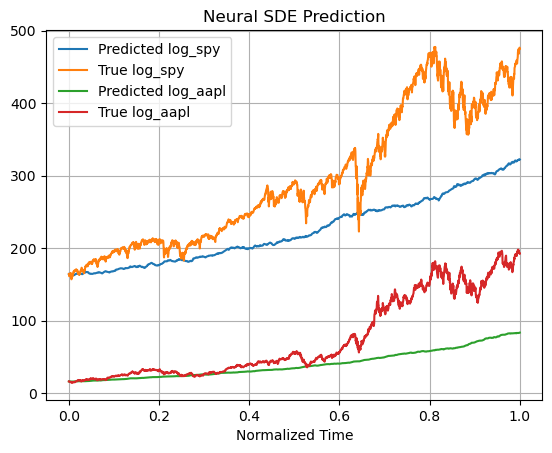

In [102]:
model.last_hidden = None  # 重置隐藏状态
# 使用训练好的模型进行预测
y0 = y[0].unsqueeze(0)  # shape: (1, D)
pred_y = torchsde.sdeint(model, y0, t, method='euler')  # shape: (T, 1, D)
pred_y = pred_y[:, 0]  # 去掉 batch 维度
plot_sde_prediction(t, pred_y, y, labels=target_cols)

In [103]:
def sample_paths(sde, y0, t, n_paths=100, method='euler'):
    paths = []
    for i in range(n_paths):
        sde.last_hidden = None  # reset GRU memory
        y_path = torchsde.sdeint(sde, y0, t, method=method)  # shape: [T, D]
        paths.append(torch.exp(y_path.unsqueeze(0)))  # shape: [1, T, D]
        if i % 5 == 0:
            print(f"Loading: {i}/{n_paths}={i/n_paths*100}% completed")
    return torch.cat(paths, dim=0)  # shape: [N, T, D]
import matplotlib.pyplot as plt

def plot_path_distribution(t, samples, true=None, label="SPY"):
    t_np = t.numpy()
    mean_path = samples.mean(dim=0)  # shape: [T, D]
    std_path = samples.std(dim=0)
    y_mean = mean_path[:, 0].detach().cpu().numpy().reshape(-1)
    y_std = std_path[:, 0].detach().cpu().numpy().reshape(-1)
    print(y_mean.shape, y_std.shape)

    plt.plot(t_np, mean_path[:, 0].detach().numpy(), label=f"Mean {label}")
    plt.fill_between(
        t_np,
        y_mean - 2 * y_std,
        y_mean + 2 * y_std,
        color='blue', alpha=0.2, label="95% CI"
    )

    aapl_mean = mean_path[:, 1].detach().cpu().numpy().reshape(-1)
    aapl_std = std_path[:, 1].detach().cpu().numpy().reshape(-1)
    print(aapl_mean.shape, aapl_std.shape)

    plt.plot(t_np, mean_path[:, 1].detach().numpy(), label=f"Mean AAPL")
    plt.fill_between(
        t_np,
        aapl_mean - 2 * aapl_std,
        aapl_mean + 2 * aapl_std,
        color='red', alpha=0.2, label="95% CI"
    )


    if true is not None:
        plt.plot(t_np, true[:, 0].numpy(), label="True SPY", linewidth = 0.5, color='black')
        plt.plot(t_np, true[:, 1].numpy(), label="True AAPL", linewidth = 0.5, color='gray')

    plt.title(f"Neural SDE {label} Distribution")
    plt.xlabel("Normalized Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [104]:
samples = sample_paths(model, y0, t, n_paths=50, method='euler')
samples = samples.squeeze(2)

Loading: 0/50=0.0% completed
Loading: 5/50=10.0% completed
Loading: 10/50=20.0% completed
Loading: 15/50=30.0% completed
Loading: 20/50=40.0% completed
Loading: 25/50=50.0% completed
Loading: 30/50=60.0% completed
Loading: 35/50=70.0% completed
Loading: 40/50=80.0% completed
Loading: 45/50=90.0% completed


(2664,) (2664,)
(2664,) (2664,)


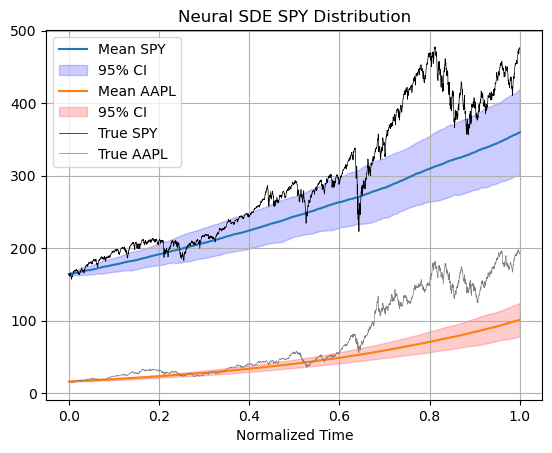

In [105]:
plot_path_distribution(t, samples, true=torch.exp(y), label="SPY")

torch.Size([105, 2])
Loading: 0/50=0.0% completed
Loading: 5/50=10.0% completed
Loading: 10/50=20.0% completed
Loading: 15/50=30.0% completed
Loading: 20/50=40.0% completed
Loading: 25/50=50.0% completed
Loading: 30/50=60.0% completed
Loading: 35/50=70.0% completed
Loading: 40/50=80.0% completed
Loading: 45/50=90.0% completed
torch.Size([50, 105, 2])
(105,) (105,)
(105,) (105,)


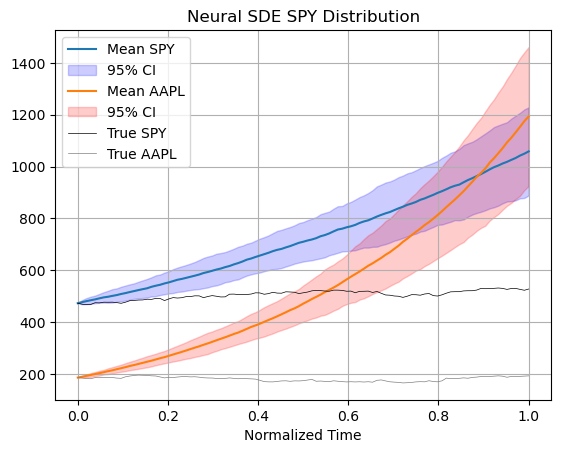

In [109]:
def model_validation(t_test, x, y):
    model.feature_data = x  # 保存特征数据到模型中
    model.last_hidden = None  # 重置隐藏状态
    print(y_test.shape)
    y0 = y_test[0].unsqueeze(0)  # 初始状态，形状为 [1, D]   
    pred_y = torchsde.sdeint(model, y0, t_test, method='euler')  # shape (T, 1, D)
    pred_y = pred_y[:, 0]  # 去掉 batch 维度
    samples = sample_paths(model, y0, t_test, n_paths=50, method='euler')
    samples = samples.squeeze(2)
    print(samples.shape)
    plot_path_distribution(t_test, samples, true=torch.exp(y_test), label="SPY")


model_validation(t_test, x_test, y_test)

## + Attention

In [107]:
import torch.nn.functional as F

class NeuralSDEFuncWithAttention(NeuralSDEFunc):
    noise_type = 'diagonal'
    sde_type = 'ito'
    def __init__(self, feature_data, output_dim, hidden_dim=64, attn_dim=32):
        super().__init__(feature_data, output_dim, hidden_dim)
        self.query = nn.Linear(hidden_dim, attn_dim)
        self.key = nn.Linear(hidden_dim, attn_dim)
        self.value = nn.Linear(hidden_dim, attn_dim)
        self.attn_out = nn.Linear(attn_dim, hidden_dim)
    # drift项引入Attention机制
    def f(self, t, y): 
        input_ = self.forward_input(t, y)
        out, self.last_hidden = self.gru(input_, self.last_hidden)
        out = out.squeeze(1)  # (batch, hidden_dim)

        # 计算Attention（单步）
        Q = self.query(out).unsqueeze(1)  # (batch, 1, attn_dim)
        K = self.key(out).unsqueeze(1)    # (batch, 1, attn_dim)
        V = self.value(out).unsqueeze(1)  # (batch, 1, attn_dim)

        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (self.hidden_dim ** 0.5)  # (batch,1,1)
        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch,1,1)
        attn_output = torch.bmm(attn_weights, V).squeeze(1)  # (batch, attn_dim)

        attn_output_proj = self.attn_out(attn_output)  # (batch, hidden_dim)

        combined = out + attn_output_proj  # 残差连接
        drift = self.f_net(combined)
        return drift
    
    @classmethod
    def train_rolling_windows(cls, t_all, x_all, y_all, window_size=10, step_size=1,
                              max_epochs=100, patience=10, lr=1e-3):
        trained_models = []
        total_len = len(t_all)

        for start in range(0, total_len - window_size, step_size):
            end = start + window_size
            t_win = t_all[start:end]
            x_win = x_all[start:end]
            y_win = y_all[start:end]
            y0 = y_win[0].unsqueeze(0)

            model = cls(x_win, y_win.shape[1])
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            best_loss = float('inf')
            patience_counter = 0

            for epoch in range(max_epochs):
                model.last_hidden = None
                pred_y = torchsde.sdeint(model, y0, t_win, method='euler')
                loss = ((pred_y - y_win) ** 2).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if loss.item() < best_loss - 1e-4:
                    best_loss = loss.item()
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"📉 Window {start}-{end}: Early stopping at epoch {epoch}, Loss = {loss.item():.4f}")
                    break

            trained_models.append(model)

        return trained_models
    

# ==== Step 7: 使用Attention机制的模型训练 ====
def twes_attention(t, x, y, max_epochs=150, patience=50, lr = 0.001):
    feature_dim = x.shape[1]
    output_dim = y.shape[1]
    model = NeuralSDEFuncWithAttention(x, output_dim)
    best_loss = float('inf')
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    y0 = y[0].unsqueeze(0)  # 初始状态，shape = (1, output_dim)
    for epoch in range(max_epochs):
        model.last_hidden = None
        pred_y = torchsde.sdeint(model, y0, t, method='euler')
        loss = ((pred_y - y) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 5 == 0 or epoch == max_epochs - 1:
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

        if loss.item() < best_loss - 1e-3:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch}.")
            return model
    return model

In [111]:
feature_cols = ["vix", "TLT_close", "IEF_close", "SHY_close",
                "daily_policy_index", "cci", "jobless_claims"]
target_cols = ["log_spy", "log_aapl"]

t, x, y, t_test, x_test, y_test= prepare_data(df, target_cols, feature_cols)
modelwa = NeuralSDEFuncWithAttention.train_rolling_windows(
    t_all=t,
    x_all=x,
    y_all=y,
    window_size=100,
    step_size=5,
    max_epochs=100,
    patience=10,
    lr=1e-3
)

📉 Window 0-100: Early stopping at epoch 34, Loss = 0.0041
📉 Window 5-105: Early stopping at epoch 29, Loss = 0.0060
📉 Window 10-110: Early stopping at epoch 36, Loss = 0.0055
📉 Window 15-115: Early stopping at epoch 24, Loss = 0.0112
📉 Window 20-120: Early stopping at epoch 13, Loss = 0.0088
📉 Window 25-125: Early stopping at epoch 23, Loss = 0.0088
📉 Window 30-130: Early stopping at epoch 15, Loss = 0.0082
📉 Window 35-135: Early stopping at epoch 20, Loss = 0.0264
📉 Window 40-140: Early stopping at epoch 23, Loss = 0.0044
📉 Window 45-145: Early stopping at epoch 25, Loss = 0.0069
📉 Window 50-150: Early stopping at epoch 28, Loss = 0.0044
📉 Window 55-155: Early stopping at epoch 56, Loss = 0.0030
📉 Window 60-160: Early stopping at epoch 13, Loss = 0.0070
📉 Window 65-165: Early stopping at epoch 19, Loss = 0.0104
📉 Window 70-170: Early stopping at epoch 17, Loss = 0.0120
📉 Window 75-175: Early stopping at epoch 10, Loss = 0.0059
📉 Window 80-180: Early stopping at epoch 14, Loss = 0.0064

tensor([6.1513, 5.2861])


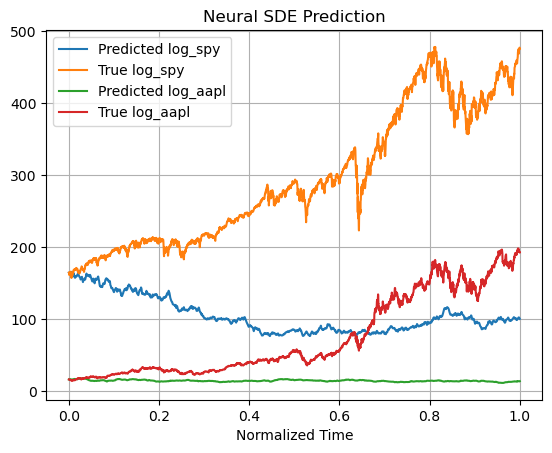

In [112]:
x_window = x[-10:]
y_window = y[-10:]
t_window = t[-10:]

# 最后一个模型
last_model = modelwa[-1]

# 重置隐藏状态
last_model.last_hidden = None
print(y[-10])
# 用 y[-10] 作为起点，预测未来 t 全段（不是只预测10个点）
y0 = y[0].unsqueeze(0)  # shape (1, D)
pred_ywa = torchsde.sdeint(last_model, y0, t, method='euler')  # shape (T, 1, D)
pred_ywa = pred_ywa[:, 0]  # 去掉 batch 维度

# 画图对比整个轨迹
plot_sde_prediction(t, pred_ywa, y, labels=target_cols)

In [113]:
sampleswa = sample_paths(model, y0, t, n_paths=50, method='euler')
sampleswa = sampleswa.squeeze(2)

Loading: 0/50=0.0% completed
Loading: 5/50=10.0% completed
Loading: 10/50=20.0% completed
Loading: 15/50=30.0% completed
Loading: 20/50=40.0% completed
Loading: 25/50=50.0% completed
Loading: 30/50=60.0% completed
Loading: 35/50=70.0% completed
Loading: 40/50=80.0% completed
Loading: 45/50=90.0% completed


(2664,) (2664,)
(2664,) (2664,)


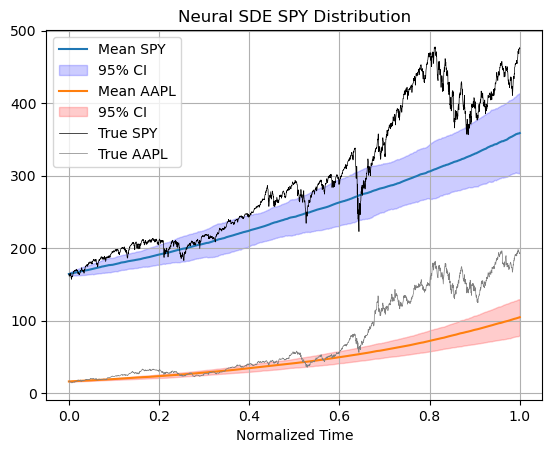

In [114]:
plot_path_distribution(t, sampleswa, true=torch.exp(y), label="SPY")

## Validation

torch.Size([105, 2])
Loading: 0/50=0.0% completed
Loading: 5/50=10.0% completed
Loading: 10/50=20.0% completed
Loading: 15/50=30.0% completed
Loading: 20/50=40.0% completed
Loading: 25/50=50.0% completed
Loading: 30/50=60.0% completed
Loading: 35/50=70.0% completed
Loading: 40/50=80.0% completed
Loading: 45/50=90.0% completed
torch.Size([50, 105, 2])
(105,) (105,)
(105,) (105,)


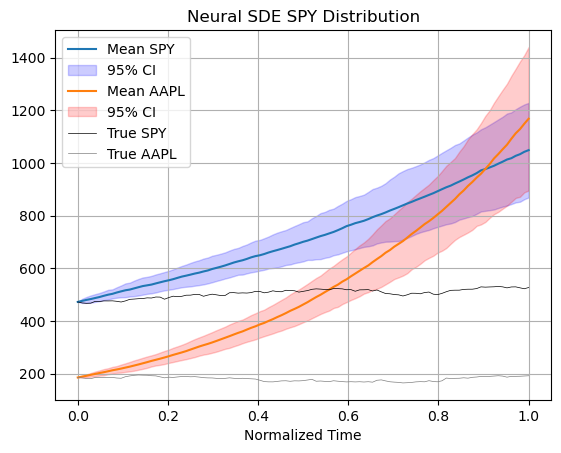

In [115]:
def model_validation(t_test, x, y):
    model.feature_data = x  # 保存特征数据到模型中
    model.last_hidden = None  # 重置隐藏状态
    print(y_test.shape)
    y0 = y_test[0].unsqueeze(0)  # 初始状态，形状为 [1, D]   
    pred_y = torchsde.sdeint(model, y0, t_test, method='euler')  # shape (T, 1, D)
    pred_y = pred_y[:, 0]  # 去掉 batch 维度
    samples = sample_paths(model, y0, t_test, n_paths=50, method='euler')
    samples = samples.squeeze(2)
    print(samples.shape)
    plot_path_distribution(t_test, samples, true=torch.exp(y_test), label="SPY")


model_validation(t_test, x_test, y_test)